In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

from agentfil import plot_utils

import copy

In [3]:
purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']

In [4]:
colors = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
results_root_dir=os.path.join(os.environ['HOME'],'agentfil','sdm')

rational_agent_type='NPVAgent'
sdm_slope=0.285

# Control Experiment
cfg_tuple = (sdm_slope, )
experiment_dirs = [
#     "SDMBaseline_%0.03f,FILP_4,25,0.50,CC_4,25,Onboard_6.00,RR_0.60,DR_20" % cfg_tuple,
#     "SDMBaseline_%0.03f,FILP_4,25,0.50,CC_4,50,Onboard_6.00,RR_0.60,DR_20" % cfg_tuple,
    "SDMBaseline_%0.03f,FILP_4,50,0.50,CC_4,50,Onboard_6.00,RR_0.60,DR_20" % cfg_tuple,
    "SDMBaseline_%0.03f,FILP_4,50,0.50,CC_4,100,Onboard_6.00,RR_0.60,DR_20" % cfg_tuple,
]
experiment_names = [
#     '25%/1x', '25%/2x', 
    '50%/1x', '50%/2x'
]

# The actual experiment
# experiment_dirs = [
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.70,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.80,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
#     "SDMExperiment=%0.03f,FILP=4,50,0.30,NormalCC=4,50,RACC=4,100,CCSplit=0.90,Onboard=6.00,RR=0.60,DR=%d" % (sdm_slope, fil_supply_discount_rate,),
# ]
# experiment_names = [
#     '30/[70/70]',
#     '30/[70/80]',
#     '30/[70/90]',
# ]

# plot settings
min_agent_plot_date = date(2023, 4, 1)
max_agent_plot_date = date(2026, 12, 31)

min_kpi_plot_date = None
max_kpi_plot_date = date(2026, 12, 31)

save_dir = os.path.join('/Users/kiran/Documents/ced_austin')

baseline_fpr = 0.8
baseline_sector_duration = 360
baseline_folder = os.path.join(os.environ['HOME'],'agentfil','baseline')
baseline_experiment = 'BaselineDCA_RBP_%0.02f-RR_%0.02f-FPR_%0.02f-Dur_%0.02f' % \
                (6, 0.6, baseline_fpr, baseline_sector_duration)
baseline_filecoin_df = pd.read_csv(os.path.join(baseline_folder, baseline_experiment, 'filecoin_df.csv'))


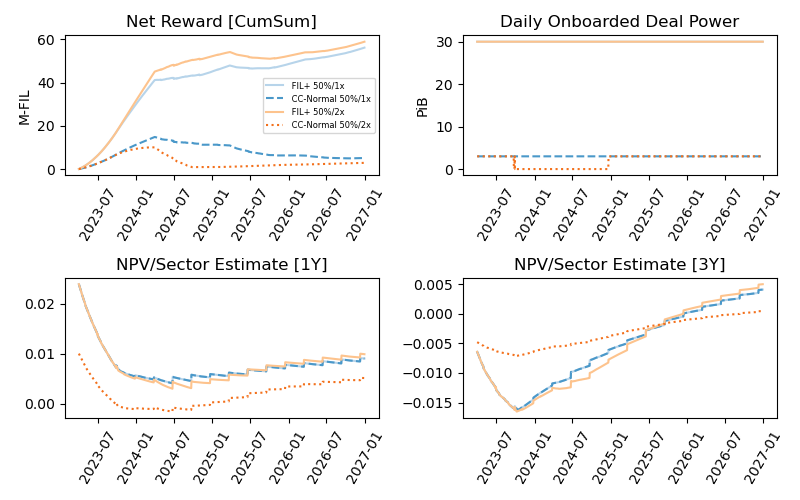

In [6]:
plt.figure(figsize=(8,5))

plt_kwargs_list = [
    [{'color': blues(0.3)}, {'color': blues(0.6), 'linestyle':'--'}, {'color': blues(0.8), 'linestyle':':'}],
    [{'color': oranges(0.3)}, {'color': oranges(0.6), 'linestyle':':'}, {'color': oranges(0.8), 'linestyle':':'}],
    [{'color': greens(0.3)}, {'color': greens(0.6), 'linestyle':'--'}, {'color': greens(0.8), 'linestyle':':'}],
    [{'color': purples(0.3)}, {'color': purples(0.6), 'linestyle':'--'}, {'color': purples(0.8), 'linestyle':':'}],
]
per_agent_label_list = ['FIL+', 'CC-Normal']


plt.subplot(2,2,1)
keys = ['reward_FIL', 'pledge_interest_payment_FIL']
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=compute_net_reward_FIL, 
               df_name='accounting_df', 
               label_postpend=exp_name, 
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('Net Reward [CumSum]')
plt.ylabel('M-FIL')
plt.legend(fontsize=6)

plt.subplot(2,2,2)
def compute_deal_onboarded(key_data):
    total_onboards = key_data['deal_onboarded']
    return total_onboards
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['cc_onboarded', 'cc_renewed', 'deal_onboarded'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=compute_deal_onboarded, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('Daily Onboarded Deal Power')
plt.ylabel('PiB')

plt.subplot(2,2,3)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_365'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [1Y]')

plt.subplot(2,2,4)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    plot_utils.plot_agent(
        results_root_dir,
        ['npv_estimate_1095'], e,
               x_post_process=plot_utils.x_post_fn,
               y_post_process=None, 
               df_name='agent_info_df', 
               label_postpend=exp_name,  
               per_agent_label_list=per_agent_label_list,
               plot_kwargs_list=plt_kwargs_list[ii],
               min_date = min_agent_plot_date, max_date = max_agent_plot_date,
              )
plt.title('NPV/Sector Estimate [3Y]')

# plt.suptitle('FILSupplyDiscountRate=%0.02f' % \
#              (fil_supply_discount_rate,))

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'danilo_q2_agent_baseline.png'))

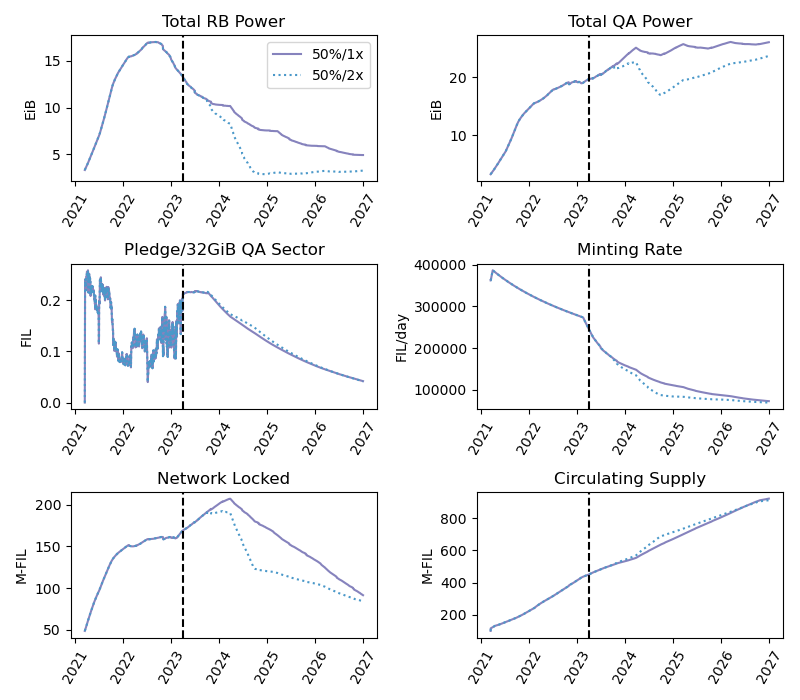

In [7]:
# plot the econometric panel
def converttoMFIL(x): return x/1e6
plt_baseline_relative = True

plt_kwargs_list = [
    {'color': purples(0.6)}, 
    {'color': blues(0.6), 'linestyle': ':', },
    {'color': greens(0.6), 'linestyle': '--'}, 
    {'color': oranges(0.6), 'linestyle': '--'}, 
    {'color': reds(0.6)}
]

plt.figure(figsize=(8,7))

plt.subplot(3,2,1)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_raw_power_eib'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=None,
                 x_key='date', labels=experiment_names,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total RB Power')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('EiB')
plt.legend()


plt.subplot(3,2,2)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_qa_power_eib'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.title('Total QA Power')
plt.ylabel('EiB')

plt.subplot(3,2,3)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_pledge_per_QAP'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.title('Pledge/32GiB QA Sector')
plt.ylabel('FIL')


plt.subplot(3,2,4)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_network_reward'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.title('Minting Rate')
plt.ylabel('FIL/day')
    

plt.subplot(3,2,5)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['network_locked'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=plot_utils.converttoMFIL,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.title('Network Locked')
plt.ylabel('M-FIL')

plt.subplot(3,2,6)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['circ_supply'], experiment_dirs, 
                 x_post_process=plot_utils.x_post_fn, 
                 y_post_process=plot_utils.converttoMFIL,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.title('Circulating Supply')
plt.ylabel('M-FIL')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'danilo_q2_kpi_baseline.png'))